# Import wymaganych bibliotek

In [5]:
import pandas as pd
import numpy as np
import ollama
import optuna
import dspy
from dspy.evaluate import Evaluate
from typing import Literal
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Import danych

In [6]:
df = pd.read_excel('data_new.xlsx', index_col=0)
df = df[['sentence','category']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  6000 non-null   object
 1   category  6000 non-null   object
dtypes: object(2)
memory usage: 140.6+ KB


In [27]:
df.nunique()

sentence         6000
category            3
sentence_size     110
dtype: int64

## Przygotowanie danych

### Wylosowanie po 1000 rekordów z każdej kategorii (dla wygody)

In [17]:
sampled_df = df.groupby('category').sample(n=1000, random_state=42)

#### Stworzenie embbedingów przy użyciu LLM

##### Należy zaciągnąć model w terminalu przy użyciu `ollama pull nomic-embed-text`

In [18]:
model = 'nomic-embed-text'

##### Zdefiniowanie funkcji embbedującej oraz zastosowanie dla danych

In [19]:
def get_embedding(text):
    response = ollama.embeddings(model=model, prompt=text)
    return response['embedding']

sampled_df['embedding'] = sampled_df['sentence'].apply(get_embedding)
sampled_df

,sentence,category,embedding
1860,"Szumowska i Englert o filmie ""All Inclusive"". ...",kultura,"[0.26709282398223877, 0.21229374408721924, -2...."
353,Raper Diddy już drugi raz w ciągu tygodnia zos...,kultura,"[0.4855307340621948, -0.5319522619247437, -2.7..."
1333,"W Kulcie przez niemal cztery dekady, stał za ""...",kultura,"[-0.1430807262659073, 0.11266040802001953, -2...."
905,Intelektualna gra Szczepana Twardocha. Recenzj...,kultura,"[-0.11897006630897522, -0.03549329563975334, -..."
1289,"""Życie pisze niesamowite scenariusze"". Ostatni...",kultura,"[0.05582632124423981, 0.6725738048553467, -2.8..."
...,...,...,...
5814,"""Zagadkowe wynurzenia"" Trumpa",swiat,"[-0.11321592330932617, 0.08005428314208984, -3..."
4074,"""Piekło"". Mieszkańcy zadają pytania o to, co s...",swiat,"[0.10850955545902252, 0.4187011122703552, -2.3..."
5298,"Zasypało drogi i miasta. ""Staram się nie myśle...",swiat,"[-0.0164395272731781, -0.1607702523469925, -2...."
5573,"Było tak zimno, że aligatory zamarzły",swiat,"[0.936455488204956, 0.11185779422521591, -2.67..."


## Eksploracja danych

In [29]:
sampled_df['sentence_size'] = sampled_df['sentence'].apply(lambda x: len(x))
sampled_df['sentence_size'].describe()

count    3000.000000
mean       69.982000
std        19.003001
min        19.000000
25%        56.000000
50%        70.000000
75%        84.000000
max       137.000000
Name: sentence_size, dtype: float64

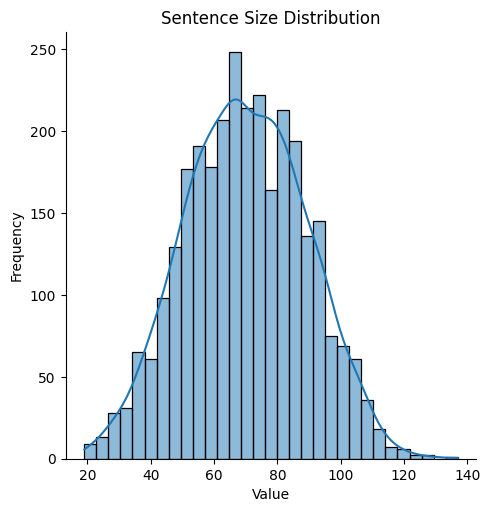

In [30]:
hist = sns.displot(sampled_df.sentence_size, kde=True)
hist.set(xlabel='Value', ylabel='Frequency', title='Sentence Size Distribution')
sns.despine()

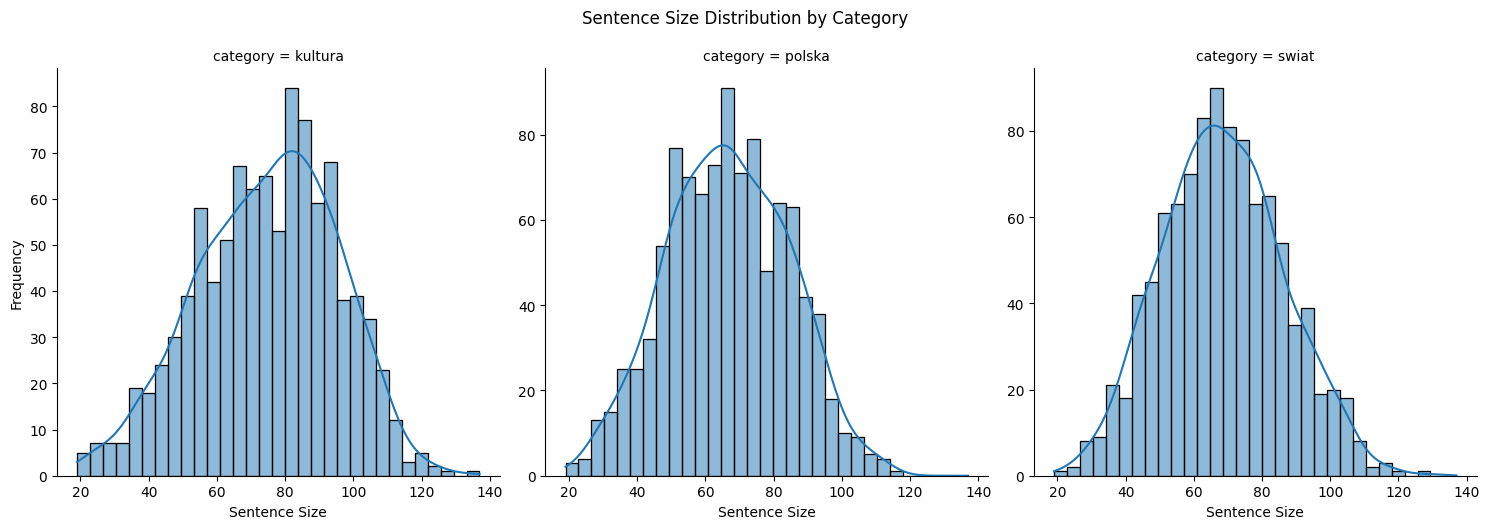

In [32]:
hist = sns.displot(
    data=sampled_df,
    x="sentence_size",
    col="category",
    kde=True,
    facet_kws={'sharey': False, 'sharex': True}
)

hist.set_axis_labels("Sentence Size", "Frequency")
hist.fig.suptitle("Sentence Size Distribution by Category", y=1.05)

sns.despine()

# Klasyfikacja

## Przygotowanie danych

### Przekształcenie embbedingów

In [ ]:
X = np.array(sampled_df['embedding'].tolist())
X

### Labelowanie kategorii

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(sampled_df['category'])
y

### Podział danych na treningowe i testowe

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Regresja logistyczna

### Zdefiniowanie eksperymentu w optuna

In [33]:
def objective_lr(trial):
    C = trial.suggest_float('C', 1e-4, 10.0, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'saga'])

    model = LogisticRegression(
        C=C,
        solver=solver,
        max_iter=1000,
        random_state=42
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return score.mean()


### Optymalizacja hiperparametrów w optuna

In [34]:
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=30)

best_params_lr = study_lr.best_trial.params

[I 2025-06-22 14:58:10,898] A new study created in memory with name: no-name-1ad552fd-678a-4e7d-9e1f-239e13557cd0
[I 2025-06-22 14:59:02,879] Trial 0 finished with value: 0.65625 and parameters: {'C': 0.013282064175833535, 'solver': 'saga'}. Best is trial 0 with value: 0.65625.
[I 2025-06-22 14:59:07,021] Trial 1 finished with value: 0.62625 and parameters: {'C': 1.506115534982126, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.65625.
C:\Users\trawi\anaconda3\envs\dspy\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

### Dopasowanie finalnego modelu

In [35]:
final_model_lr = LogisticRegression(**best_params_lr, max_iter=1000, random_state=42)
final_model_lr.fit(X_train, y_train)

y_pred = final_model_lr.predict(X_test)
test_acc_lr = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_acc_lr)

Test accuracy: 0.705


### Macierz pomyłek dla Regresji Logistycznej

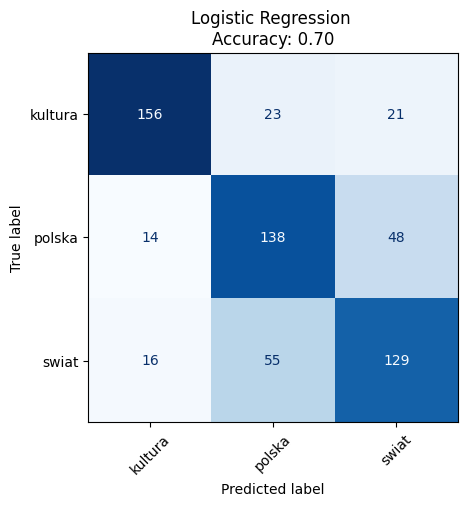

In [36]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
plt.title(f"Logistic Regression \nAccuracy: {test_acc_lr:.2f}")
plt.show()

## Las Losowy

### Zdefiniowanie eksperymentu w optuna

In [37]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return score.mean()

### Optymalizacja hiperparametrów w optuna

In [38]:
study_rfc = optuna.create_study(direction='maximize')
study_rfc.optimize(objective, n_trials=100)

best_params_rfc = study_rfc.best_trial.params

[I 2025-06-22 15:07:02,082] A new study created in memory with name: no-name-c4af7880-51b2-4ae3-b215-93c8037e7623
[I 2025-06-22 15:07:04,069] Trial 0 finished with value: 0.6166666666666667 and parameters: {'n_estimators': 231, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.6166666666666667.
[I 2025-06-22 15:07:05,027] Trial 1 finished with value: 0.6100000000000001 and parameters: {'n_estimators': 50, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6166666666666667.
[I 2025-06-22 15:07:07,861] Trial 2 finished with value: 0.6391666666666667 and parameters: {'n_estimators': 203, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6391666666666667.
[I 2025-06-22 15:07:12,493] Trial 3 finished with value: 0.64 and parameters: {'n_estimators': 290, 'max_depth': 20, 'min_samples_split

### Dopasowanie finalnego modelu

In [39]:
final_model_rfc = RandomForestClassifier(**best_params_rfc, random_state=42)
final_model_rfc.fit(X_train, y_train)

y_pred = final_model_rfc.predict(X_test)
test_acc_rfc = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_acc_rfc)

Test accuracy: 0.665


### Macierz pomyłek dla Lasu Losowego

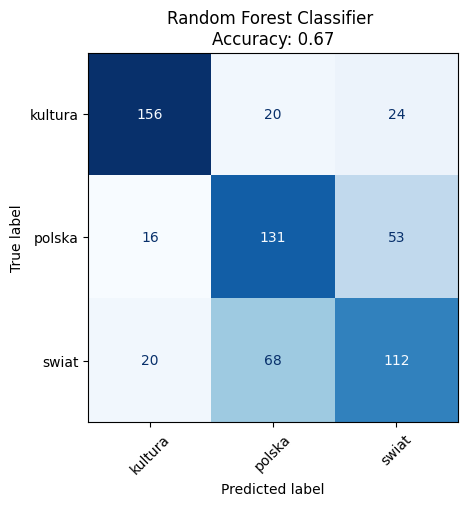

In [40]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
plt.title(f"Random Forest Classifier \nAccuracy: {test_acc_rfc:.2f}")
plt.show()

## MLP Classifier

### Zdefiniowanie eksperymentu w optuna

In [64]:
def objective_mlp(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_layer_sizes = []
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 32, 256)
        hidden_layer_sizes.append(n_units)
    hidden_layer_sizes = tuple(hidden_layer_sizes)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])

    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        solver=solver,
        max_iter=1000,
        random_state=42,
        early_stopping=True
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return score.mean()

### Optymalizacja hiperparametrów w optuna

In [ ]:
study_mlp = optuna.create_study(direction='maximize')
study_mlp.optimize(objective_mlp, n_trials=100)

best_params_mlp = study_mlp.best_trial.params

C:\Users\trawi\anaconda3\envs\dspy\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:787: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\trawi\anaconda3\envs\dspy\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:787: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\trawi\anaconda3\envs\dspy\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:787: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\trawi\anaconda3\envs\dspy\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:787: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\trawi\anaconda3\envs\dspy\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:787: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Us

### Dopasowanie finalnego modelu

In [ ]:
final_model_mlp = MLPClassifier(
    activation='relu',
    alpha=0.004458550642884175,
    learning_rate_init=0.00021239068986588354,
    solver='adam',
    max_iter=1000,
    random_state=42
)

final_model_mlp.fit(X_train, y_train)

y_pred = final_model_mlp.predict(X_test)
test_acc_mlp = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc_mlp:.2f}")

### Macierz pomyłek dla MLP Classifier

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
plt.title(f"MLP Classifier \nAccuracy: {test_acc_mlp:.2f}")
plt.show()

## Large Language Model

### Wstępny prompt

#### Uruchomienie modelu

##### Należy zaciągnąć model w terminalu przy użyciu `ollama pull llama3`

In [45]:
lm = dspy.LM('ollama_chat/llama3', api_base='http://localhost:11434', api_key='')
dspy.configure(lm=lm)

#### Zdefinowanie Sygnatury w dspy

In [46]:
class ClassifyHeadline(dspy.Signature):
    """Przyporządkuj tekst do jednej z kategorii.
    Dodatkowo wytłumacz dlaczego tak postanowiłeś w języku polskim.
    Przy wyborze kategorii zwróć uwagę na to w jakim kraju miały miejsce wydażenia lub jakiej narodowości były wspomniane tam osoby.
    Jeśli tekst dotyczy wydażeń w polsce wybierz kategorię polska. Jeśli tekst dotyczy wydarzenia z poza polski wybierz świat.
    Jeśli tekst dotyczy wydarzenia kulturalnego wybierz kategorię kultura"""
    sentence: str = dspy.InputField(desc="The news headline to classify")
    category: Literal[
    "kultura",
    "polska",
    "swiat"
    ] = dspy.OutputField(desc="The predicted category for the headline")
    reason: str = dspy.OutputField()


#### Zdefinowanie Modułu w dspy

In [47]:
class HeadlineClassifier(dspy.Module):
    def __init__(self):
        super().__init__()
        self.classifier = dspy.ChainOfThought(ClassifyHeadline)

    def forward(self, sentence):
        return self.classifier(sentence=sentence)

module = HeadlineClassifier()

#### Przygotowanie danych treningowych

In [48]:
trainset_df = df.groupby('category').sample(n=100, random_state=42)

trainset = [
    dspy.Example(sentence=row['sentence'], category=row['category']).with_inputs('sentence')
    for _, row in trainset_df.iterrows()
]

#### Zdefiniowanie ewaluatoraa

In [49]:
def validate_category(example, prediction, trace=None):
    return prediction.category == example.category

#### Ewaluacja na wstępnym prompcie

In [50]:
evaluator = Evaluate(
    devset=trainset, 
    num_threads=1, 
    display_progress=True, 
    display_table=30, 
    provide_traceback=True
)

evaluated_data = evaluator(
    module, 
    metric=validate_category, 
    return_outputs=True
)

Average Metric: 197.00 / 300 (65.7%): 100%|██████████████████████████████████████████| 300/300 [16:12<00:00,  3.24s/it]

2025/06/22 15:35:26 INFO dspy.evaluate.evaluate: Average Metric: 197 / 300 (65.7%)


,sentence,example_category,reasoning,pred_category,reason,validate_category
0,"Szumowska i Englert o filmie ""All Inclusive"". ""To było jak powrót ...",kultura,"Tekst dotyczy filmu i jego recepcji, co sugeruje, że jest to wydar...",kultura,Wypowiedź Szumowskiej i Englerta o powrocie do korzeni filmu wskaz...,✔️ [True]
1,Raper Diddy już drugi raz w ciągu tygodnia został pozwany za napaś...,kultura,"Tekst dotyczy wydarzenia związkanego z kulturą (rap), ale także ma...",swiat,"Dlatego wybór kategorii ""świat"" jest uzasadniony, ponieważ wydarze...",
2,"W Kulcie przez niemal cztery dekady, stał za ""Arahją"". Nie żyje Ja...",kultura,"Tekst opisuje życiorys i śmierć Janusza Grudzińskiego, który przez...",kultura,Janusz Grudziński był związany z Kulcie przez niemal cztery dekady...,✔️ [True]
3,"Intelektualna gra Szczepana Twardocha. Recenzja nowej książki ""Pow...",kultura,"Recenzja książki to typowy przykład wydarzenia kulturalnego, które...",kultura,"Książka ""Powiedzmy, że Piontek"" jest recenzowaną przez autora Szcz...",✔️ [True]
4,"""Życie pisze niesamowite scenariusze"". Ostatni odcinek ""Bitwy o go...",kultura,"Tekst jest tytułem odcinka serialu, który opowiada historię. Odcin...",polska,"Wybór kategorii 'polska' wynika z tego, że serial jest polskim pro...",
5,Co obejrzeć w Halloween? Dziesięć najlepszych filmów,kultura,"Film ""Halloween"" jest klasycznym horrorów, a lista najlepszych fil...",kultura,"Wybór kategorii ""kultura"" wynika z faktu, że tekst dotyczy filmów,...",✔️ [True]
6,"Gwiazdor ""Miami Vice"" opowiedział o zmaganiach z rakiem. ""Było nap...",kultura,"Gwiazdor ""Miami Vice"" opowiedział o swoich zmaganiach z rakiem, co...",kultura,"Gwiazdor ""Miami Vice"" opowiedział o swoich zmaganiach z rakiem, co...",✔️ [True]
7,WOŚP na antenie TVN i TTV jeszcze przed Finałem,kultura,"Tekst dotyczy wydarzenia kulturalnego, ponieważ WOŚP to organizacj...",kultura,"Wybór kategorii kultura wynika z tego, że tekst dotyczy organizacj...",✔️ [True]
8,"Oscary 2024. Wszystko, co warto wiedzieć o 96. gali wręczenia Nagr...",kultura,"Tekst dotyczy wydarzenia kulturalnego, czyli wręczenia Nagród Akad...",kultura,"Wybór kategorii ""kultura"" oparty jest na tym, że tekst dotyczy wyd...",✔️ [True]
9,"""Warto było zacisnąć zęby"". Marcin Dorociński u boku światowych sław",kultura,"Tekst dotyczy wydarzenia kulturalnego, ponieważ wymieniony aktor M...",kultura,"Warto było zacisnąć zęby - to tytuł artykułu, który sugeruje, że c...",✔️ [True]


#### Macierz pomyłek dla wstępnego promtu

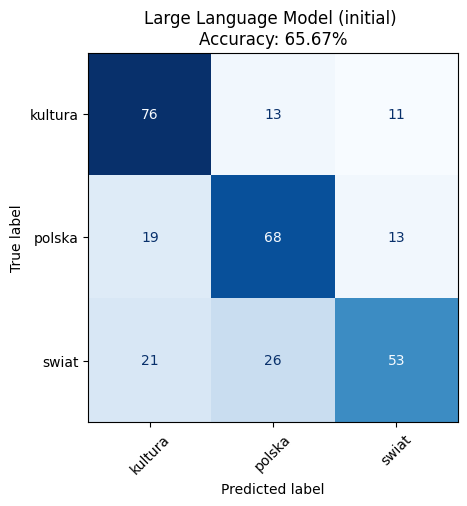

In [51]:
accuracy_score, examples = evaluated_data

y_true = [ex['category'] for ex, _, _ in examples]
y_pred = [pred['category'] for _, pred, _ in examples]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = sorted(set(y_true + y_pred))
cm = confusion_matrix(y_true, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
plt.title(f"Large Language Model (initial) \nAccuracy: {accuracy_score:.2f}%")
plt.show()

#### Optymalizacja promptu

In [52]:
tp = dspy.MIPROv2(
    metric=validate_category, 
    auto ="light"
)
optimized = tp.compile(
    module, 
    trainset = trainset, 
    requires_permission_to_run = False
)

2025/06/22 15:35:26 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: True
num_candidates: 5
valset size: 100

2025/06/22 15:35:26 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/06/22 15:35:26 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/06/22 15:35:26 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=5 sets of demonstrations...


Bootstrapping set 1/5
Bootstrapping set 2/5
Bootstrapping set 3/5


 10%|████████▎                                                                          | 6/60 [00:12<01:56,  2.15s/it]


Bootstrapped 4 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.
Bootstrapping set 4/5


  3%|██▊                                                                                | 2/60 [00:04<01:57,  2.03s/it]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 5/5


 12%|█████████▋                                                                         | 7/60 [00:18<02:17,  2.59s/it]
2025/06/22 15:36:01 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/06/22 15:36:01 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Bootstrapped 4 full traces after 7 examples for up to 1 rounds, amounting to 7 attempts.


2025/06/22 15:36:05 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...

2025/06/22 15:37:58 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/06/22 15:37:58 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Przyporządkuj tekst do jednej z kategorii.
Dodatkowo wytłumacz dlaczego tak postanowiłeś w języku polskim.
Przy wyborze kategorii zwróć uwagę na to w jakim kraju miały miejsce wydażenia lub jakiej narodowości były wspomniane tam osoby.
Jeśli tekst dotyczy wydażeń w polsce wybierz kategorię polska. Jeśli tekst dotyczy wydarzenia z poza polski wybierz świat.
Jeśli tekst dotyczy wydarzenia kulturalnego wybierz kategorię kultura

2025/06/22 15:37:58 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Analyze the given sentence and categorize it into one of three categories: "kultura" (culture), "polska" (Polish), or "swiat" (world). Provide a detailed reasoning in Polish explaining why you chose this category. When selecting a category, consider wh

Average Metric: 68.00 / 100 (68.0%): 100%|█████████████████████████████████████████| 100/100 [00:00<00:00, 1150.78it/s]

2025/06/22 15:37:59 INFO dspy.evaluate.evaluate: Average Metric: 68 / 100 (68.0%)
2025/06/22 15:37:59 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 68.0

C:\Users\trawi\anaconda3\envs\dspy\lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/06/22 15:37:59 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 10 - Minibatch ==



Average Metric: 25.00 / 35 (71.4%): 100%|██████████████████████████████████████████████| 35/35 [00:42<00:00,  1.21s/it]

2025/06/22 15:38:41 INFO dspy.evaluate.evaluate: Average Metric: 25 / 35 (71.4%)
2025/06/22 15:38:41 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 1'].
2025/06/22 15:38:41 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43]
2025/06/22 15:38:41 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [68.0]
2025/06/22 15:38:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2025/06/22 15:38:41 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/06/22 15:38:41 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 10 - Minibatch ==



Average Metric: 19.00 / 35 (54.3%): 100%|██████████████████████████████████████████████| 35/35 [00:22<00:00,  1.57it/s]

2025/06/22 15:39:03 INFO dspy.evaluate.evaluate: Average Metric: 19 / 35 (54.3%)
2025/06/22 15:39:03 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 54.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 1'].
2025/06/22 15:39:03 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 54.29]
2025/06/22 15:39:03 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [68.0]
2025/06/22 15:39:03 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2025/06/22 15:39:03 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/06/22 15:39:03 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 10 - Minibatch ==



Average Metric: 27.00 / 35 (77.1%): 100%|██████████████████████████████████████████████| 35/35 [00:31<00:00,  1.11it/s]

2025/06/22 15:39:35 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)
2025/06/22 15:39:35 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 1'].
2025/06/22 15:39:35 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 54.29, 77.14]
2025/06/22 15:39:35 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [68.0]
2025/06/22 15:39:35 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2025/06/22 15:39:35 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/06/22 15:39:35 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 10 - Minibatch ==



Average Metric: 20.00 / 35 (57.1%): 100%|██████████████████████████████████████████████| 35/35 [00:15<00:00,  2.26it/s]

2025/06/22 15:39:50 INFO dspy.evaluate.evaluate: Average Metric: 20 / 35 (57.1%)
2025/06/22 15:39:50 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 57.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 1'].
2025/06/22 15:39:50 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 54.29, 77.14, 57.14]
2025/06/22 15:39:50 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [68.0]
2025/06/22 15:39:50 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2025/06/22 15:39:50 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/06/22 15:39:50 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 10 - Minibatch ==



Average Metric: 23.00 / 35 (65.7%): 100%|██████████████████████████████████████████████| 35/35 [00:26<00:00,  1.32it/s]

2025/06/22 15:40:17 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/06/22 15:40:17 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 3'].
2025/06/22 15:40:17 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 54.29, 77.14, 57.14, 65.71]
2025/06/22 15:40:17 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [68.0]
2025/06/22 15:40:17 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2025/06/22 15:40:17 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/06/22 15:40:17 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 10 - Full Evaluation =====
2025/06/22 15:40:17 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 77.14) from minibatch trials...



Average Metric: 65.00 / 100 (65.0%): 100%|███████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]

2025/06/22 15:41:13 INFO dspy.evaluate.evaluate: Average Metric: 65 / 100 (65.0%)
2025/06/22 15:41:13 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [68.0, 65.0]
2025/06/22 15:41:13 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2025/06/22 15:41:13 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/06/22 15:41:13 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/06/22 15:41:13 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 10 - Minibatch ==



Average Metric: 27.00 / 35 (77.1%): 100%|██████████████████████████████████████████████| 35/35 [00:27<00:00,  1.29it/s]

2025/06/22 15:41:40 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)
2025/06/22 15:41:40 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 1'].
2025/06/22 15:41:40 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 54.29, 77.14, 57.14, 65.71, 77.14]
2025/06/22 15:41:40 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [68.0, 65.0]
2025/06/22 15:41:40 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2025/06/22 15:41:40 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/06/22 15:41:40 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 10 - Minibatch ==



Average Metric: 20.00 / 35 (57.1%): 100%|██████████████████████████████████████████████| 35/35 [00:37<00:00,  1.08s/it]

2025/06/22 15:42:18 INFO dspy.evaluate.evaluate: Average Metric: 20 / 35 (57.1%)
2025/06/22 15:42:18 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 57.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 4'].
2025/06/22 15:42:18 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [71.43, 54.29, 77.14, 57.14, 65.71, 77.14, 57.14]
2025/06/22 15:42:18 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [68.0, 65.0]
2025/06/22 15:42:18 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2025/06/22 15:42:18 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/06/22 15:42:18 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 10 / 10 - Full Evaluation =====
2025/06/22 15:42:18 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 77.14) from minibatch trials...



Average Metric: 73.00 / 100 (73.0%): 100%|███████████████████████████████████████████| 100/100 [00:46<00:00,  2.15it/s]

2025/06/22 15:43:05 INFO dspy.evaluate.evaluate: Average Metric: 73 / 100 (73.0%)
2025/06/22 15:43:05 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 73.0
2025/06/22 15:43:05 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [68.0, 65.0, 73.0]
2025/06/22 15:43:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 73.0
2025/06/22 15:43:05 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/06/22 15:43:05 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/06/22 15:43:05 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 73.0!


In [53]:
optimized

classifier.predict = Predict(StringSignature(sentence -> reasoning, category, reason
    instructions='Przyporządkuj tekst do jednej z kategorii.\nDodatkowo wytłumacz dlaczego tak postanowiłeś w języku polskim.\nPrzy wyborze kategorii zwróć uwagę na to w jakim kraju miały miejsce wydażenia lub jakiej narodowości były wspomniane tam osoby.\nJeśli tekst dotyczy wydażeń w polsce wybierz kategorię polska. Jeśli tekst dotyczy wydarzenia z poza polski wybierz świat.\nJeśli tekst dotyczy wydarzenia kulturalnego wybierz kategorię kultura'
    sentence = Field(annotation=str required=True json_schema_extra={'desc': 'The news headline to classify', '__dspy_field_type': 'input', 'prefix': 'Sentence:'})
    reasoning = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${reasoning}', '__dspy_field_type': 'output'})
    category = Field(annotation=Literal['kultura', 'polska', 'swiat'] required=True json_schema_extra={'desc': '

### Zoptymalizowany prompt

#### Przygotowanie danych testowych

In [54]:
validset_df = df.groupby('category').sample(n=100, random_state=21)

validset = [
    dspy.Example(sentence=row['sentence'], category=row['category']).with_inputs('sentence')
    for _, row in validset_df.iterrows()
]

#### Ewaluacja na zoptymalizowanym prompcie

In [55]:
evaluator = Evaluate(
    devset=validset, 
    num_threads=1, 
    display_progress=True
)

eval_results = evaluator(
    optimized, 
    metric=validate_category, 
    return_outputs=True
)

Average Metric: 190.00 / 300 (63.3%): 100%|██████████████████████████████████████████| 300/300 [10:48<00:00,  2.16s/it]

2025/06/22 15:53:53 INFO dspy.evaluate.evaluate: Average Metric: 190 / 300 (63.3%)


#### Macierz pomyłek dla zoptymalizowanego promptu

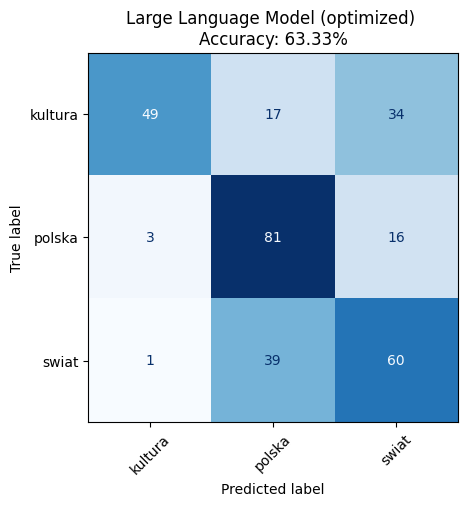

In [56]:
accuracy_score, examples = eval_results

y_true = [ex['category'] for ex, _, _ in examples]
y_pred = [pred['category'] for _, pred, _ in examples]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = sorted(set(y_true + y_pred))
cm = confusion_matrix(y_true, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
plt.title(f"Large Language Model (optimized) \nAccuracy: {accuracy_score:.2f}%")
plt.show()

# Wyniki

In [57]:
all_rows = []

models = {
    "Logistic Regression": final_model_lr,
    "Random Forest": final_model_rfc,
    "MLP Classifier": final_model_mlp
}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    
    report_dict = classification_report(
        y_test, y_pred, target_names=label_encoder.classes_, output_dict=True
    )
    
    for label, metrics in report_dict.items():
        if label in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        
        row = {
            'category': label,
            'model': model_name,
            **metrics
        }
        all_rows.append(row)

comparison_df = pd.DataFrame(all_rows)
comparison_df.set_index(['model', 'category'], inplace=True)
comparison_df = comparison_df.round(3).sort_index()

pd.set_option("display.max_columns", None)

In [58]:
accuracy_score, examples = evaluated_data

y_true = [ex['category'] for ex, _, _ in examples]
y_pred = [pred['category'] for _, pred, _ in examples]

target_names = sorted(set(y_true + y_pred))

report_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

df_llm_report = pd.DataFrame(report_dict).T

In [59]:
llm_rows = []

for label, metrics in report_dict.items():
    if label in ['accuracy', 'macro avg', 'weighted avg']:
        continue

    row = {
        'model': 'LLM',
        'category': label,
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1-score': metrics['f1-score']
    }
    llm_rows.append(row)

df_llm = pd.DataFrame(llm_rows)
df_llm.set_index(['model', 'category'], inplace=True)
df_llm = df_llm.round(3)

comparison_df = pd.concat([comparison_df, df_llm]).sort_index()
comparison_df = comparison_df.drop(columns='support')

## Wydajność modeli (zdefiniowana jako F1-score) w podziale na kategorie

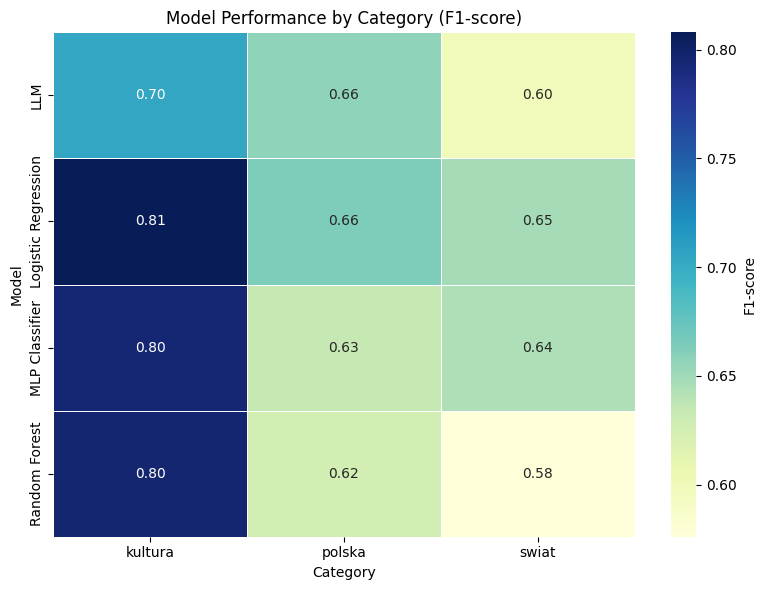

In [60]:
heatmap_data = comparison_df['f1-score'].unstack(level='category')

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'F1-score'}
)

plt.title("Model Performance by Category (F1-score)")
plt.ylabel("Model")
plt.xlabel("Category")
plt.tight_layout()
plt.show()

## Porównanie metryk

In [61]:
comparison_df

precision  recall  f1-score
model               category                             
LLM                 kultura       0.655   0.760     0.704
                    polska        0.636   0.680     0.657
                    swiat         0.688   0.530     0.599
Logistic Regression kultura       0.839   0.780     0.808
                    polska        0.639   0.690     0.663
                    swiat         0.652   0.645     0.648
MLP Classifier      kultura       0.785   0.805     0.795
                    polska        0.649   0.620     0.634
                    swiat         0.637   0.650     0.644
Random Forest       kultura       0.812   0.780     0.796
                    polska        0.598   0.655     0.625
                    swiat         0.593   0.560     0.576

## Podsumowanie

1. **Kategorie**

> Najłatwiejszą do odgadnięcia kategorią dla każdego modelu okazała się Kultura.
> 
> Wynikać to może z tego, że Kultura ma bardzo charakterystyczny słownik i frazy
> 
> (np. nazwiska artystów, tytuły filmów, wydarzenia kulturalne, słowa kluczowe jak „wystawa”, „premiera”, „teatr”),
> 
> które są łatwe do wychwycenia przez model.

> Każdy z użytych modeli gorzej poradził sobie z odróżnieniem kategorii Polska i Świat.
>
> Wynikać to może z tego, że obie te kategorie mogą obejmować bardzo różnorodne tematy:
>
> polityka, gospodarka, społeczeństwo, sport itp.
>
> Granice między wiadomościami o Polsce i o Świecie mogą być rozmyte 
>
> np. wydarzenia polityczne lub gospodarcze mające zasięg międzynarodowy lub dotyczące Polski w kontekście światowym.
   
2. **Modele**

> Regresja Logistyczna osiągnęła najlepsze i najstabilniejsze wyniki, co sugeruje, że prosty model liniowy dobrze pasuje do danych i cech.
>
> MLP i Lasy Losowe uzyskały zbliżone wyniki do Regresji Logistycznej, ale mogą potrzebować dalszej optymalizacji.
>
> LLM (o dziwo!) uzyskał najsłabsze wyniki.
>
> Model LLaMA 3 jest głównie trenowany na dużych zbiorach tekstów w języku angielskim (ale również innych językach).
>
> Słabe wyniki tego modelu mogą sugerować potrzebę dodatkowego fine-tuningu na polskich tekstach.